### 86.75 점

In [1]:
import warnings
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils, to_categorical
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pirl/anaconda3/envs/vne

In [2]:
# load dataset list

train_data = pd.read_csv("train_vision.csv")
train_filename = train_data["filename"].values.tolist()
train_data["label"] = train_data["label"] -1
train_label = train_data["label"].values.tolist()

test_data = pd.read_csv("test_vision.csv")
test_filename = test_data["filename"].values.tolist()

print(len(train_filename), len(train_label), len(test_filename))

5850 5850 2000


In [3]:
# load train data
input_height , input_width = 128, 128
n_class = 6

def getImageArr(img_name):
        img = cv2.imread("faces_images/" + img_name, 1)
        img = np.float32(img) / 127.5 - 1   #0~255 를 평균 0이게 수정
        return img

X = []
for name in train_filename:
    X.append(getImageArr(name))
    
X, Y = np.array(X), to_categorical(np.array(train_label),n_class)
print(X.shape, Y.shape)

(5850, 128, 128, 3) (5850, 6)


In [4]:
# split dataset

train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
# X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4972, 128, 128, 3) (4972, 6)
(878, 128, 128, 3) (878, 6)


In [5]:
# load test data

real_test = []
for name in test_filename:
    real_test.append(getImageArr(name))
    
real_test = np.array(real_test)
print(real_test.shape)

(2000, 128, 128, 3)


In [6]:
 def nn_base(nClasses, input_height=128, input_width=128):
        
    img_input = Input(shape=(input_height,input_width, 3))
        
    IMAGE_ORDERING =  "channels_last"
    
    x = Conv2D(32,(3, 3),activation = 'relu', padding='same', name='image_array', data_format=IMAGE_ORDERING)(img_input)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(3, 3), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64,(3, 3),activation = 'relu', padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64,(3, 3),activation = 'relu', padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2), data_format=IMAGE_ORDERING )(x)
    x = Dropout(.25)(x)

    x = Conv2D(64,(3, 3),activation = 'relu', padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64,(3, 3),activation = 'relu', padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(3, 3), data_format=IMAGE_ORDERING )(x)
    x = Dropout(.25)(x)

    x = Conv2D(128,(3, 3),activation = 'relu', padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128,(3, 3),activation = 'relu', padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2), data_format=IMAGE_ORDERING )(x)
    x = Dropout(.25)(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(2048, activation='relu', name='fc1')(x)
    x = BatchNormalization()(x)
    x = Dropout(.5)(x)
    
    x = Dense(n_class , activation='softmax', name='predictions')(x)
    
    model = Model(img_input, x)

    return model

In [7]:
model = nn_base(nClasses  = n_class,  
             input_height = 128, 
             input_width  = 128)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
image_array (Conv2D)         (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 42, 42, 64)        256       
__________

In [9]:
with K.tf.device('/gpu:1'):
    sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    hist1 = model.fit(X_train,y_train,
                      validation_data=(X_test,y_test),
                      batch_size=32,epochs=50)

Train on 4972 samples, validate on 878 samples
Epoch 1/50
4972/4972 [==============================] - 6s 1ms/step - loss: 1.4523 - acc: 0.7009 - val_loss: 1.4495 - val_acc: 0.6800
Epoch 2/50
4972/4972 [==============================] - 5s 926us/step - loss: 1.1490 - acc: 0.7474 - val_loss: 1.1669 - val_acc: 0.7551
Epoch 3/50
4972/4972 [==============================] - 5s 910us/step - loss: 1.4112 - acc: 0.6947 - val_loss: 1.0118 - val_acc: 0.6902
Epoch 4/50
4972/4972 [==============================] - 5s 909us/step - loss: 1.3727 - acc: 0.7182 - val_loss: 2.8772 - val_acc: 0.6708
Epoch 5/50
4972/4972 [==============================] - 5s 914us/step - loss: 1.1276 - acc: 0.7546 - val_loss: 4.6930 - val_acc: 0.6048
Epoch 6/50
4972/4972 [==============================] - 5s 920us/step - loss: 1.1017 - acc: 0.7422 - val_loss: 0.4680 - val_acc: 0.8474
Epoch 7/50
4972/4972 [==============================] - 5s 924us/step - loss: 0.9719 - acc: 0.7816 - val_loss: 0.4859 - val_acc: 0.8485
Epo

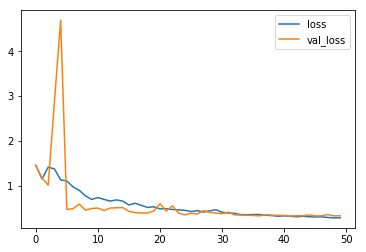

In [10]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [11]:
y_pred = model.predict(real_test)
y_predi = np.argmax(y_pred,axis = 1) + 1
print(np.unique(y_predi), y_predi.shape)

[1 2 3 4 5 6] (2000,)


In [12]:
answer = pd.DataFrame({"prediction":y_predi})

In [13]:
answer.to_csv('results/6-5.csv',index=False, header="label")